In [1]:
import numpy as np
import matplotlib.pyplot as plt
import coordinates as coords
import ctypes
import json

In [2]:
library = ctypes.cdll.LoadLibrary('../go/rkf45.so')

In [3]:
init = library.InitIntegrator
init.argtypes = [ctypes.c_char_p]

dostep = library.DoStep
dostep.argtypes = [ctypes.c_char_p]

getstate = library.GetState
getstate.argtypes = [ctypes.c_char_p]
getstate.restype = ctypes.c_void_p

def_init_params = {
    "name":"test1",
    "acc_func":"schwarzschild",
    "dtau0":1e-8,
    "err":1e-8,
    "t":0.0,
    "x1":10.0,
    "x2":0.0,
    "x3":0.0,
    "vt":1.0,
    "vx1":0.0,
    "vx2":0.0,
    "vx3":0.0,
}
init(json.dumps(def_init_params).encode('utf-8'))

dostep("test1".encode('utf-8'))

state = json.loads(ctypes.string_at(getstate("test1".encode('utf-8'))))
print(state)

{'dtau': 6.807184803404938e-06, 't': 1e-08, 'tau': 1e-08, 'vt': 1, 'vx1': -7.999999999999998e-07, 'vx2': 0, 'vx3': 0, 'x1': 9.999999999999996, 'x2': 0, 'x3': 0}


2025/02/14 15:31:42 starting init...
2025/02/14 15:31:42 &{0xc000198038 8 10 1.0000000000000001e-16 1e-08 0 0 [0 10 0 0 1 0 0 0] [[0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0]]}
2025/02/14 15:31:42 init successful


In [4]:
def compute_geodesic(tau_max,evals,init_ps):
    ev_ats = np.linspace(0,tau_max,evals)
    pn = init_ps["name"].encode('utf-8')
    init(json.dumps(init_ps).encode('utf-8'))

    states = []
    evai = 0
    for _ in range(evals*9999999):
        if evai > 0:
            dostep(pn)
        state = json.loads(ctypes.string_at(getstate(pn)))
        states.append([state["tau"],state["t"],state["x1"],state["x2"]])
        evai += 1
        if state["t"] >= ev_ats[-1]:
            break
        
        #if state["t"]+2*state["vt"]*state["dtau"] > ev_ats[evai] or state["t"]-2*state["vt"]*state["dtau"]<ev_ats[evai]:
        #    states.append([state["tau"],state["t"],state["x1"],state["x2"]])
        
        #while evai < evals and state["t"] >= ev_ats[evai]:
        #    evai += 1
        #if evai >= evals:
        #    break
    states = np.array(states).T
    print(states.shape)
    return states

In [5]:
init_ps = def_init_params
init_ps["x2"] = np.pi/4
init_ps["vx2"] = 2.0
init_ps["err"] = 1e-5
zs = compute_geodesic(12.0, 1000, init_ps)

2025/02/14 15:31:42 starting init...
2025/02/14 15:31:42 &{0xc000198038 8 10 1.0000000000000002e-10 1e-08 0 0 [0 10 0.7853981633974483 0 1 0 2 0] [[0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0]]}
2025/02/14 15:31:42 init successful


(4, 289)


/tmp/ipykernel_31462/2397636852.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


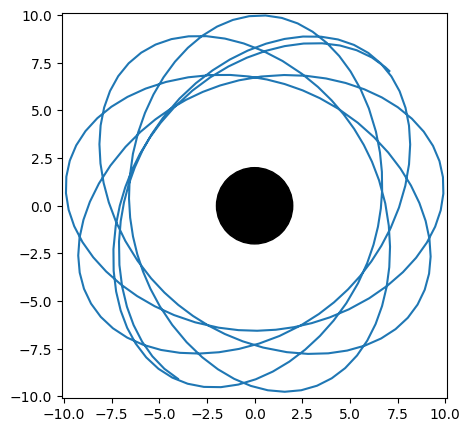

In [6]:
#plt.plot(data[0],data[1])
rs = coords.conv_coords([zs[2],zs[3],np.zeros_like(zs[0])], "cylindrical", "cartesian")[:2]
fig, ax = plt.subplots(1,figsize=(5,5),dpi=100)
ax.plot(rs[0],rs[1])
ax.add_patch(plt.Circle((0, 0), 2.0, color='k'))
ax.set_aspect(1)
ax.set_xlim(-10.1,10.1)
ax.set_ylim(-10.1,10.1)
fig.show()